In [1]:
!pip install scgpt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 13.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00:00:

In [2]:
import scgpt as scg
import scanpy as sc
import scib
import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/opt/conda/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
import os
from pathlib import Path
import warnings


import numpy as np
import sys

import matplotlib.pyplot as plt
import anndata

plt.style.context('default')
warnings.simplefilter("ignore", ResourceWarning)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dataset-mouse-cell-atlas/filtered_total_sample_ext_organ_celltype_batch.txt
/kaggle/input/dataset-mouse-cell-atlas/filtered_total_batch1_seqwell_batch2_10x.txt
/kaggle/input/mouse-atlas/adata_mouse_atlas.h5ad
/kaggle/input/human-pancreas/adata_human_pancreas.h5ad
/kaggle/input/scgpt-human/scGPT_human/vocab.json
/kaggle/input/scgpt-human/scGPT_human/args.json
/kaggle/input/scgpt-human/scGPT_human/best_model.pt


In [4]:
import importlib
import sys
import numpy as np
from scipy import sparse
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

smaple_data_path = '/kaggle/input/human-pancreas/adata_human_pancreas.h5ad'
adata = sc.read_h5ad(smaple_data_path)

gene_col = "gene_name"
cell_type_key = "cell_type"
batch_key = "sample"
N_HVG = 1800

# Check for genes with all zeros
zero_gene_mask = (adata.X.sum(axis=0) == 0).A1 if sparse.issparse(adata.X) else (adata.X.sum(axis=0) == 0)
print(f"Number of zero-valued genes: {np.sum(zero_gene_mask)}")

# Remove genes with all zero values
adata = adata[:, ~zero_gene_mask]
if isinstance(adata.X, np.ndarray):
    data_matrix = adata.X
else:
    data_matrix = adata.X.toarray() 
    
# Prevent torchvision from fully importing
def custom_import(name, *args, **kwargs):
    if name == 'torchvision._meta_registrations':
        return None
    return importlib.import_module(name, *args, **kwargs)

sys.modules['torchvision._meta_registrations'] = None

# Now proceed with embedding the data
model_dir = r"/kaggle/input/scgpt-human/scGPT_human/"
gene_col = "gene_name"  
cell_type_key = "cell_type"
batch_key = "sample"
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

CUDA available: True
Number of zero-valued genes: 0
scGPT - INFO - match 14815/15558 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 231/231 [03:02<00:00,  1.26it/s]


In [5]:
# First, compute neighbors if not already done
sc.pp.neighbors(adata, use_rep='X')  # or specify another representation if needed

# Then compute UMAP
sc.tl.umap(adata)

In [6]:
# After creating embed_adata, compute UMAP for it too
sc.pp.neighbors(embed_adata, use_rep='X')
sc.tl.umap(embed_adata)

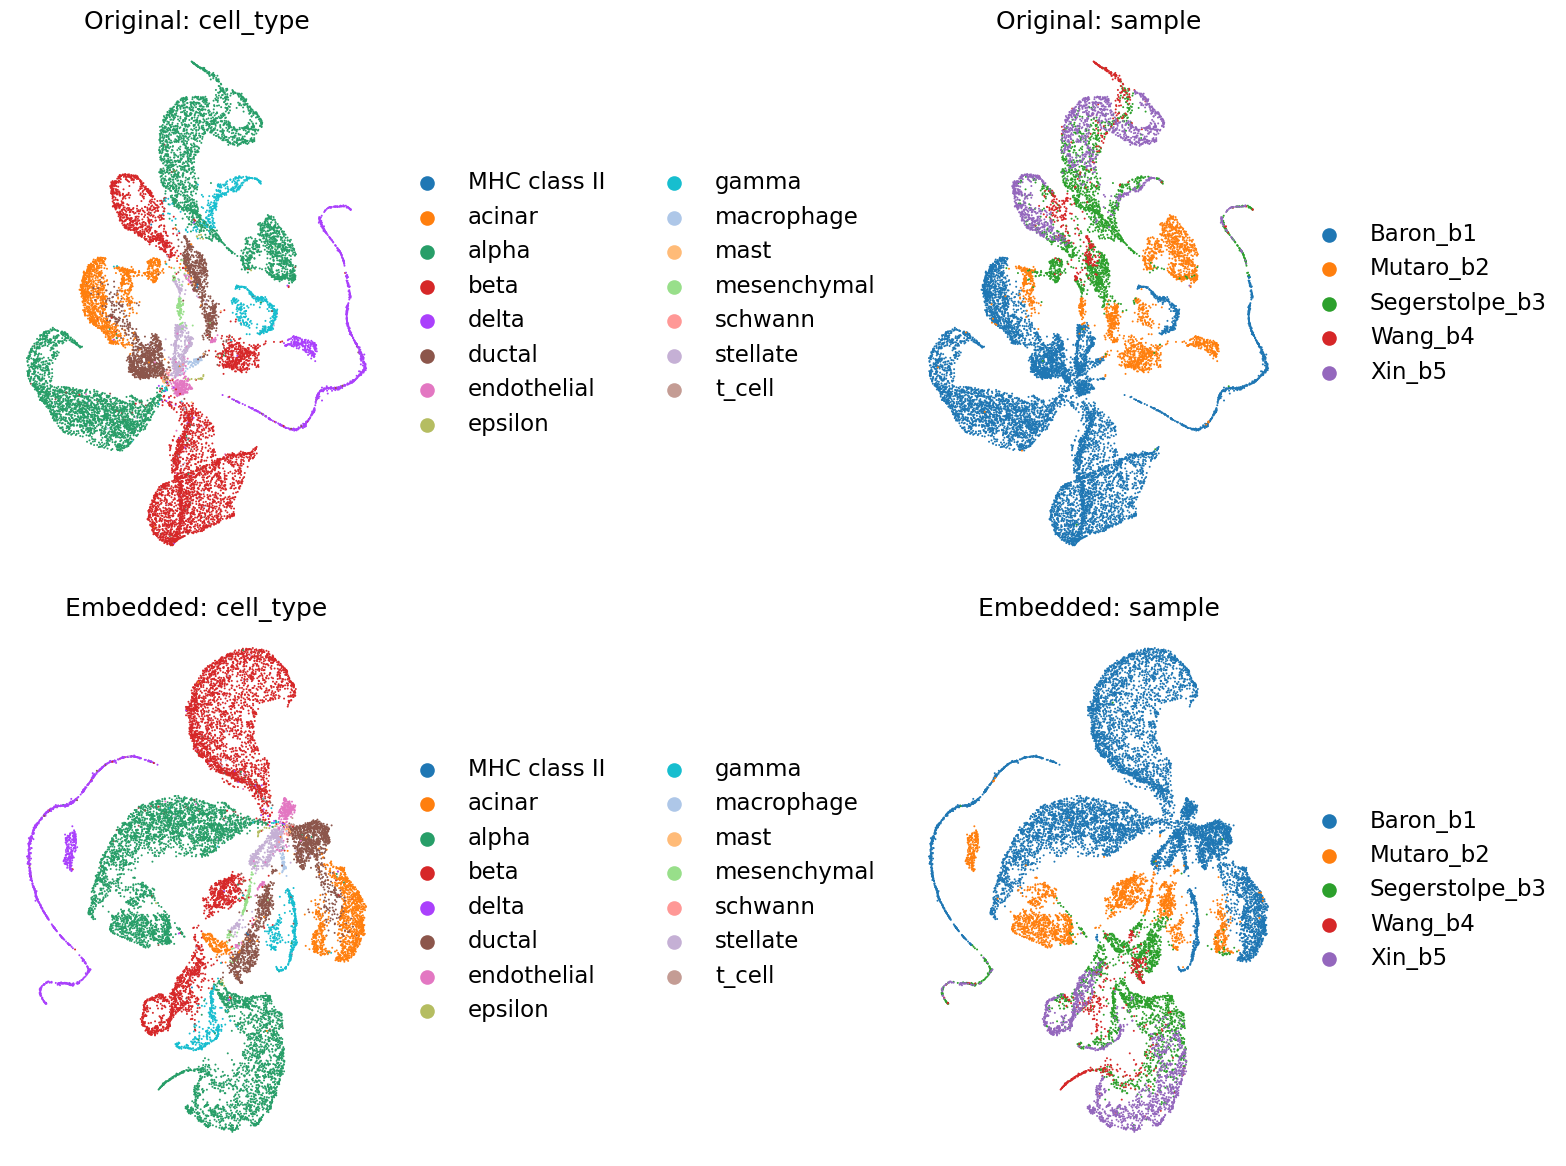

Original dataset shape: (14767, 15558)
Embedded dataset shape: (14767, 14815)


In [7]:
# Create side-by-side plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


# Plot original data - cell type
sc.pl.umap(adata, 
           color=cell_type_key, 
           frameon=False, 
           title=f"Original: {cell_type_key}",
           ax=ax1,
           show=False)

# Plot original data - batch
sc.pl.umap(adata, 
           color=batch_key, 
           frameon=False, 
           title=f"Original: {batch_key}",
           ax=ax2,
           show=False)

# Plot embedded data - cell type
sc.pl.umap(embed_adata, 
           color=cell_type_key, 
           frameon=False, 
           title=f"Embedded: {cell_type_key}",
           ax=ax3,
           show=False)

# Plot embedded data - batch
sc.pl.umap(embed_adata, 
           color=batch_key, 
           frameon=False, 
           title=f"Embedded: {batch_key}",
           ax=ax4,
           show=False)

plt.tight_layout()
plt.show()

# Optional: Compute and print some quantitative comparisons
print("Original dataset shape:", adata.shape)
print("Embedded dataset shape:", embed_adata.shape)

In [17]:
def calculate_metrics(adata, embed_adata, batch_key='sample', label_key='cell_type', embed_key='X_pca'):
    """
    Calculate integration metrics: LISI, kBET, and ASW scores
    
    Parameters:
    -----------
    adata : AnnData
        Original dataset
    embed_adata : AnnData
        Embedded/integrated dataset
    batch_key : str
        Name of batch column in obs
    label_key : str
        Name of cell type column in obs
    embed_key : str
        Key for embedding in obsm (e.g., 'X_pca', 'X_umap')
    """
    
    # Calculate LISI scores
    # Corrected by adding label_key parameter
    batch_lisi = scib.me.lisi_graph(embed_adata, batch_key, label_key, type_='full')
    cell_type_lisi = scib.me.lisi_graph(embed_adata, label_key, batch_key, type_='full')
    
    print(f"Batch Mean LISI Scores: {np.mean(batch_lisi)}")
    print(f"Batch Median LISI Scores: {np.median(batch_lisi)}")
    print(f"Celltype Mean LISI Scores: {np.mean(cell_type_lisi)}")
    print(f"Celltype Median LISI Scores: {np.median(cell_type_lisi)}")
    
    # Calculate kBET score
    # kbet_score = scib.me.kBET(embed_adata, batch_key, embed_key, type = 'full')
    # print(f"kBET score: {kbet_score}")
    
    # Calculate ASW scores
    asw_label = scib.me.silhouette(embed_adata, label_key, embed_key)
    asw_batch = scib.me.silhouette(embed_adata, batch_key, embed_key)
    print(f"ASW (CellType): {asw_label}")
    print(f"ASW (Batch): {asw_batch}")
    
    return {
        'batch_lisi': batch_lisi,
        'cell_type_lisi': cell_type_lisi,
        # 'kbet': kbet_score,
        'asw_label': asw_label,
        'asw_batch': asw_batch
    }

calculate_metrics(adata, embed_adata, batch_key='sample', label_key='cell_type', embed_key='X_pca')

Batch Mean LISI Scores: 0.4997674063981132
Batch Median LISI Scores: 0.4997674063981132
Celltype Mean LISI Scores: 0.5002325936018868
Celltype Median LISI Scores: 0.5002325936018868
ASW (CellType): 0.1322249174118042
ASW (Batch): 0.5474909991025925


{'batch_lisi': (9.659610581613798e-05, 0.9994382166904102),
 'cell_type_lisi': (0.0005617833095897014, 0.9999034038941839),
 'asw_label': 0.1322249174118042,
 'asw_batch': 0.5474909991025925}